# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

You will be marked for your code presentation, design, results, and report. Please note this notebook should take no more than 10 minutes to run on lab computers. 

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [496]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt


Now you can load the data:

In [497]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

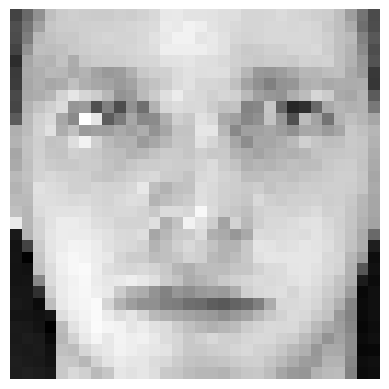

In [498]:
# Display a single example.
show_single_face(data[0, :])

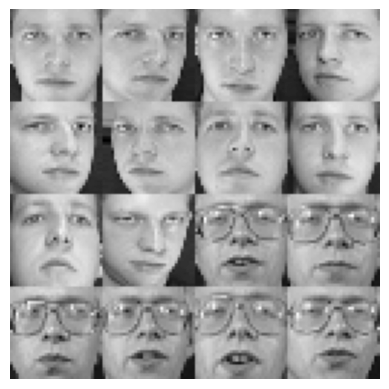

In [499]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [500]:
# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares (5 marks, Normal)
### 3.1 Implementation
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ (lambda) as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [501]:
def l2_rls_train(data, labels, lmbd): # Add any other arguments here
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"
    lmbd: type and description of "lmbd"

    Returns: type and description of the returned variable(s).
    
    # explanation
    data -  matrix of input data samples.
    labels -  matrix of output values. For single-output cases, labels will be a vector.
    lmbd -  regularization parameter (lambda) that controls the trade-off between minimizing the sum of squares loss and the L2-norm of the model weights.

    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.hstack((np.ones((X.shape[0],1)),X))
    X_tilde_transpose = np.transpose(X_tilde)
    
    #identity matrix
    I = np.eye(X_tilde.shape[1])
    
    if(lmbd == 0):
        w = np.linalg.pinv(X_tilde) @ y
    if(lmbd > 0):
        w = np.linalg.inv(X_tilde_transpose @ X_tilde + lmbd*I) @ X_tilde_transpose @ y

    
    # Return model parameters.
    return w

Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [502]:
def l2_rls_predict(w, data):
    """
    A summary of your function goes here.

    data: type and description of "data"
    w: type and description of "w"

    Returns: type and description of the returned variable(s).

    # explanation
    w - trained weight matrix returned by the l2_rls_train function.
    data - matrix of input data samples where each row represents a sample and each column represents a feature of that sample.
    """
    
    X = data
    X_tilde = np.hstack((np.ones((X.shape[0],1)),X))
    
   # Compute the prediction.  
    predicted_y = X_tilde @ w
        
    return predicted_y


### 3.2 Report

Explain briefly the knowledge supporting your implementation and your design step by step. Explicitly comment on the role of any arguments you have added to your functions. 

## 4. Face Recognition (4 Marks, Normal)
### 4.1 Implementation and experiment design

Use your implemented functions to perform multi-class classification to identify the subject in each image, for all 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [503]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

##Setup


# lmd_vals = [0, 0.001, 0.01, 0.02, 0.03, 0.1, 0.2, 0.3, 1, 3, 3, 4, 5, 6, 7, 8, 9 , 10, 100, 1000]
lmbd = np.logspace(-4, 3, num=8)
lmbd_list = list(lmbd)

tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

# Encode the categorical labels using one-hot encoding
encoder = OneHotEncoder(sparse=False)
tr_label_encoded = encoder.fit_transform(tr_label.reshape(-1, 1))


def KSplitData(train, val, lmbd):
    split_tr_data = tr_data[train]
    split_tr_label = tr_label_encoded[train]
    split_val_data = tr_data[val]
    split_val_label = tr_label_encoded[val]

    # Train the model using L2-regularized least squares
    w = l2_rls_train(split_tr_data, split_tr_label, lmbd)
    return w, split_tr_data, split_tr_label, split_val_data, split_val_label


    

/Users/chittesh/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [504]:
## Experiment

# Initialize variables for storing results
cm = np.zeros((40, 40))
avg_acc = 0
best_acc = 0 

# Use k-fold cross-validation to select the best lambda value
best_lmbd = None
best_lmbd_list = []
training_acc_list = []
average_accuracy_lmd_list = []

training_acc = 0
kf = KFold(n_splits= 10, shuffle=True)

for ld in lmbd_list:
    average_accuracy_lmd = 0
    for train, val in kf.split(tr_data):
#         print(train)
        w, s_tr_data, s_tr_label, s_val_data, s_val_label = KSplitData(train, val, ld)
        # Evaluate the model on the validation set
        predicted_validation = l2_rls_predict(w, s_val_data)
        accuracy_validation = accuracy_score(np.argmax(predicted_validation, axis=1), np.argmax(s_val_label, axis=1))
        average_accuracy_lmd += accuracy_validation / 10

    # Select the lambda value with the highest average accuracy on the validation sets
    if average_accuracy_lmd > training_acc:
        training_acc = average_accuracy_lmd
        training_acc_list.append(training_acc)
        average_accuracy_lmd_list.append(average_accuracy_lmd)
        best_lmbd_list.append(ld)


max_acc_lmd = max(training_acc_list)
max_acc_lmd_ind = training_acc_list.index(max_acc_lmd)
best_lmbd = best_lmbd_list[max_acc_lmd_ind]
#     print(best_lmbd)



if best_lmbd is not None:
    print(f"Best lambda value: {best_lmbd:.3f}")
else:
    print("No lambda value found")

print(f"Training accuracy = {training_acc:.3f}")

# print(f"Lambda = {best_lmbdbest_lambda:.3f},Training accuracy = {best_acc:.3f}")
print(f"Average accuracy: {average_accuracy_lmd:.3f}")

# Train the model using the selected lambda value and all training data

w = l2_rls_train(tr_data, tr_label_encoded, best_lmbd)


# Evaluate the model on the test set
te_pred = l2_rls_predict(w, te_data)

te_acc = accuracy_score(np.argmax(te_pred, axis=1)+1, te_label)
# print(np.argmax(te_pred, axis=1)+1)
# print(te_label)
# avg_acc += te_acc 

# Compute the confusion matrix for the test set
cm += confusion_matrix(te_label, np.argmax(te_pred, axis=1), labels=np.arange(40))

print(f"Test accuracy: {te_acc:.3f}")
print("Confusion matrix: \n", cm)




Best lambda value: 1.000
Training accuracy = 0.900
Average accuracy: 0.265
Test accuracy: 0.935
Confusion matrix: 
 [[0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 5. 0. 0.]
 [0. 0. 0. ... 0. 5. 0.]]


 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

Images for class 39
Images for class 38
Images for class 17
Images for class 16
Images for class 15


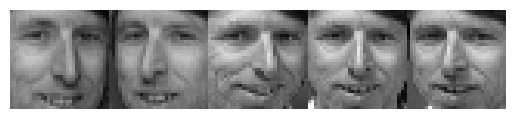

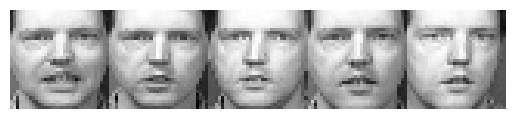

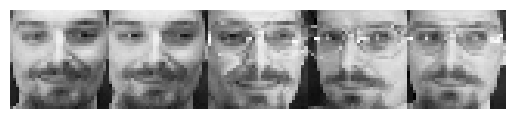

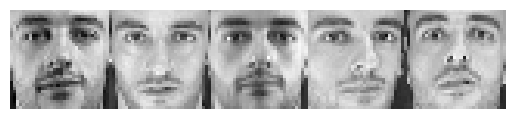

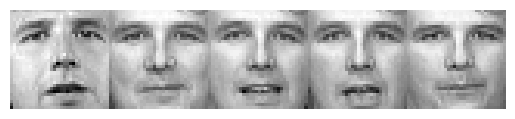

In [505]:
# Find the indices of the classes with the highest diagonal values in the confusion matrix
easy_classes = np.argsort(np.diag(cm))[::-1][:5]

# Find the indices of the test images corresponding to the easiest classes
easy_indices = [np.where(te_label == i)[0] for i in easy_classes]

# Plot the test images from the easiest classes
for i, indices in enumerate(easy_indices):
    print(f"Images for class {easy_classes[i]}")
    show_faces(te_data[indices], num_per_row=len(indices))




 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

Subject 19:
Subject 22:
Subject 23:
Subject 24:
Subject 25:


/var/folders/fp/3vfjr6990f9cptlhd_ntrmzm0000gn/T/ipykernel_1245/3785978721.py:4: RuntimeWarning: invalid value encountered in divide
  accuracies = correct_predictions / true_labels


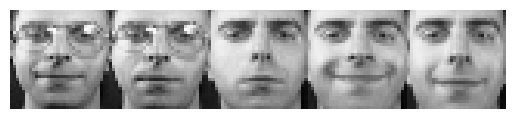

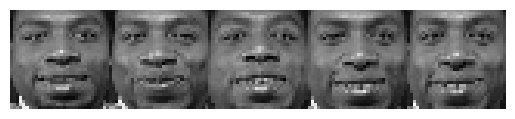

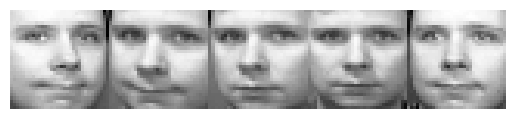

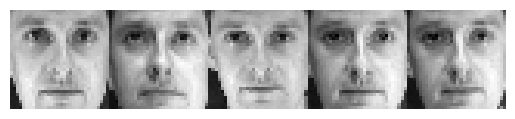

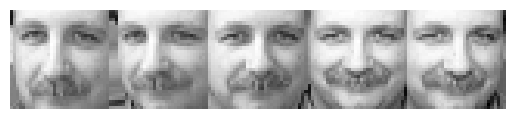

In [506]:
true_labels = cm.sum(axis=1)
predicted_labels = cm.sum(axis=0)
correct_predictions = np.diag(cm)
accuracies = correct_predictions / true_labels
difficult_subjects = np.argsort(accuracies)[:5]
for subject in difficult_subjects:
    print(f"Subject {subject}:")
    misclassified_indices = np.where((te_label == subject) & (np.argmax(te_pred, axis=1) != subject))[0]
    show_faces(te_data[misclassified_indices][:16, :], num_per_row=5)




### 4.2 Report

Explain the classification steps, and report your chosen hyper-parameter and results on the test set. Did you notice any common features among the easiest and most difficult subjects to classify? Describe your observations and analyse your results.

## 5. Face Completion (4 Marks, Normal)
In this task you will predict the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [507]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

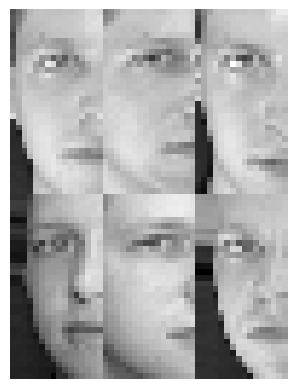

In [508]:
show_split_faces(left[:6, :], num_per_row=3)

### 5.1 Implementation and experiment design

Build a face completion model using your regularised least squares model. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error (MAPE) to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [509]:
# Step 1: Define a training set and a test set.
# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = left[tr_ind, :]
tr_label = right[tr_ind]
te_data = left[te_ind, :]
te_label = right[te_ind]


# Step 2: Train the model using the training set.
lmbd = 0 # set lambda to 0
w = l2_rls_train(tr_data, tr_label, lmbd)

# Step 3: Predict the right face pixels from the left face pixels of the test set.
right_pred = l2_rls_predict(w, te_data)


# Step 5: Evaluate the model performance using mean absolute percentage error (MAPE).
mape = np.mean(np.abs(te_label - right_pred) / te_label) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 21.86%


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

Random numbers: [255, 25, 138]


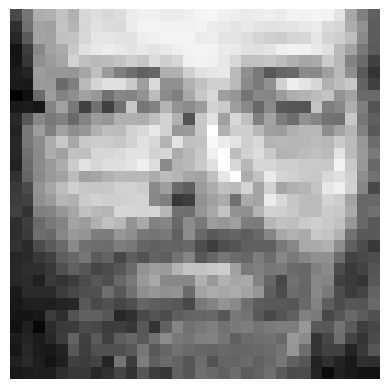

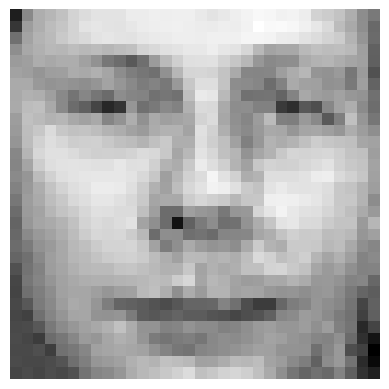

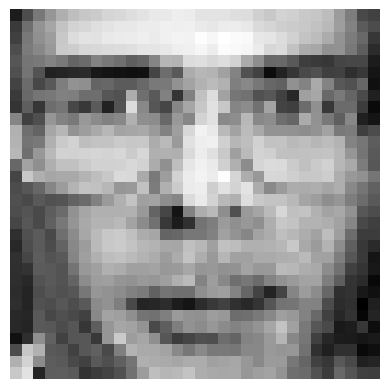

In [510]:
from random import sample

# Generate 3 random numbers between 0 and the number of test samples
random_numbers = sample(range(0, len(te_data)), 3)

# Print the generated numbers
print(f"Random numbers: {random_numbers}")

# Concatenate the left and right halves of the ground truth faces
ground_truth_faces = join_left_right(te_data, right_pred)

# Concatenate the left and true left and predicted right parts of the completed faces
completed_faces = join_left_right(te_data, te_label)

# Show the selected ground truth faces and completed faces
for i in random_numbers:
    show_single_face(ground_truth_faces[i, :])


### 5.2 Report

Report the MAPE and make some observations regarding the results of the face completion model. How well has your model performed? Offer one suggestion for how it can be improved.


## 6. Training linear least squares model via gradient descent (5 marks, Normal)
For these experiments you will be performing **binary classification.** 
### 6.1 GD Implementation
Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [511]:
import numpy as np

def lls_gd_train(data, labels, N, learning_rate):
    """
    Trains a single-output linear model by minimizing the sum of squares loss using the gradient descent approach.

    data: numpy array of shape (m, n), where m is the number of examples and n is the number of features.
    labels: numpy array of shape (m, 1), where m is the number of examples.
    N: number of iterations to run the gradient descent algorithm.
    learning_rate: the learning rate to be used in the gradient descent algorithm.

    Returns:
    cost_all: a numpy array of shape (N,) containing the cost of the linear least squares model at each iteration.
    w_all: a numpy array of shape (N, n+1) containing the weights of the linear least squares model at each iteration.
    """

    # This is just to be consistent with the lecture notes.
    X, y = data, labels

    # Expand X with a column of ones.
    X_tilde = np.hstack((np.ones((X.shape[0],1)),X))

    # Weight initialization
    w = np.zeros(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((N, X_tilde.shape[1]))
    cost_all = np.zeros((N))



    # GD update of weights
    for i in range(N):

        # cost and gradient descent of the linear least squares model
        y_pred = np.dot(X_tilde, w)
        error = y - y_pred
        cost = np.sum( error ** 2 ) / (2 * X_tilde.shape[0])
        
        dp = np.dot(X_tilde, w)
        gradient = (np.dot(X_tilde.T, dp ) - np.dot(X_tilde.T, y) )
        gradient /= X_tilde.shape[0]

        # Weight update
        w -= (learning_rate * gradient)

        # save w and cost of each iteration in w_all and cost_all 
        w_all[i] = w
        cost_all[i] = cost


    # Return model parameters.
    return cost_all, w_all


## 6. Training linear least squares model via gradient descent (5 marks, Normal)
For these experiments you will be performing *binary classification.* 
### 6.1 GD Implementation
Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [512]:
#SETUP
# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)

ind_1 = tr_ind[0:3]
ind_30 = tr_ind[87:90]
total_train_ind = np.concatenate((ind_1,ind_30))

train_data = data[total_train_ind, :]
train_label = labels[total_train_ind]

#getting the indices for 1's and 30's from the testing set
ind_1 = te_ind[0:7]
ind_30 = te_ind[203:210]

#getting the final testing indices which has the indices for both sample 1 and sample 30.
total_test_ind = np.concatenate((ind_1,ind_30))

test_data = data[te_ind, :]
test_label = labels[te_ind]

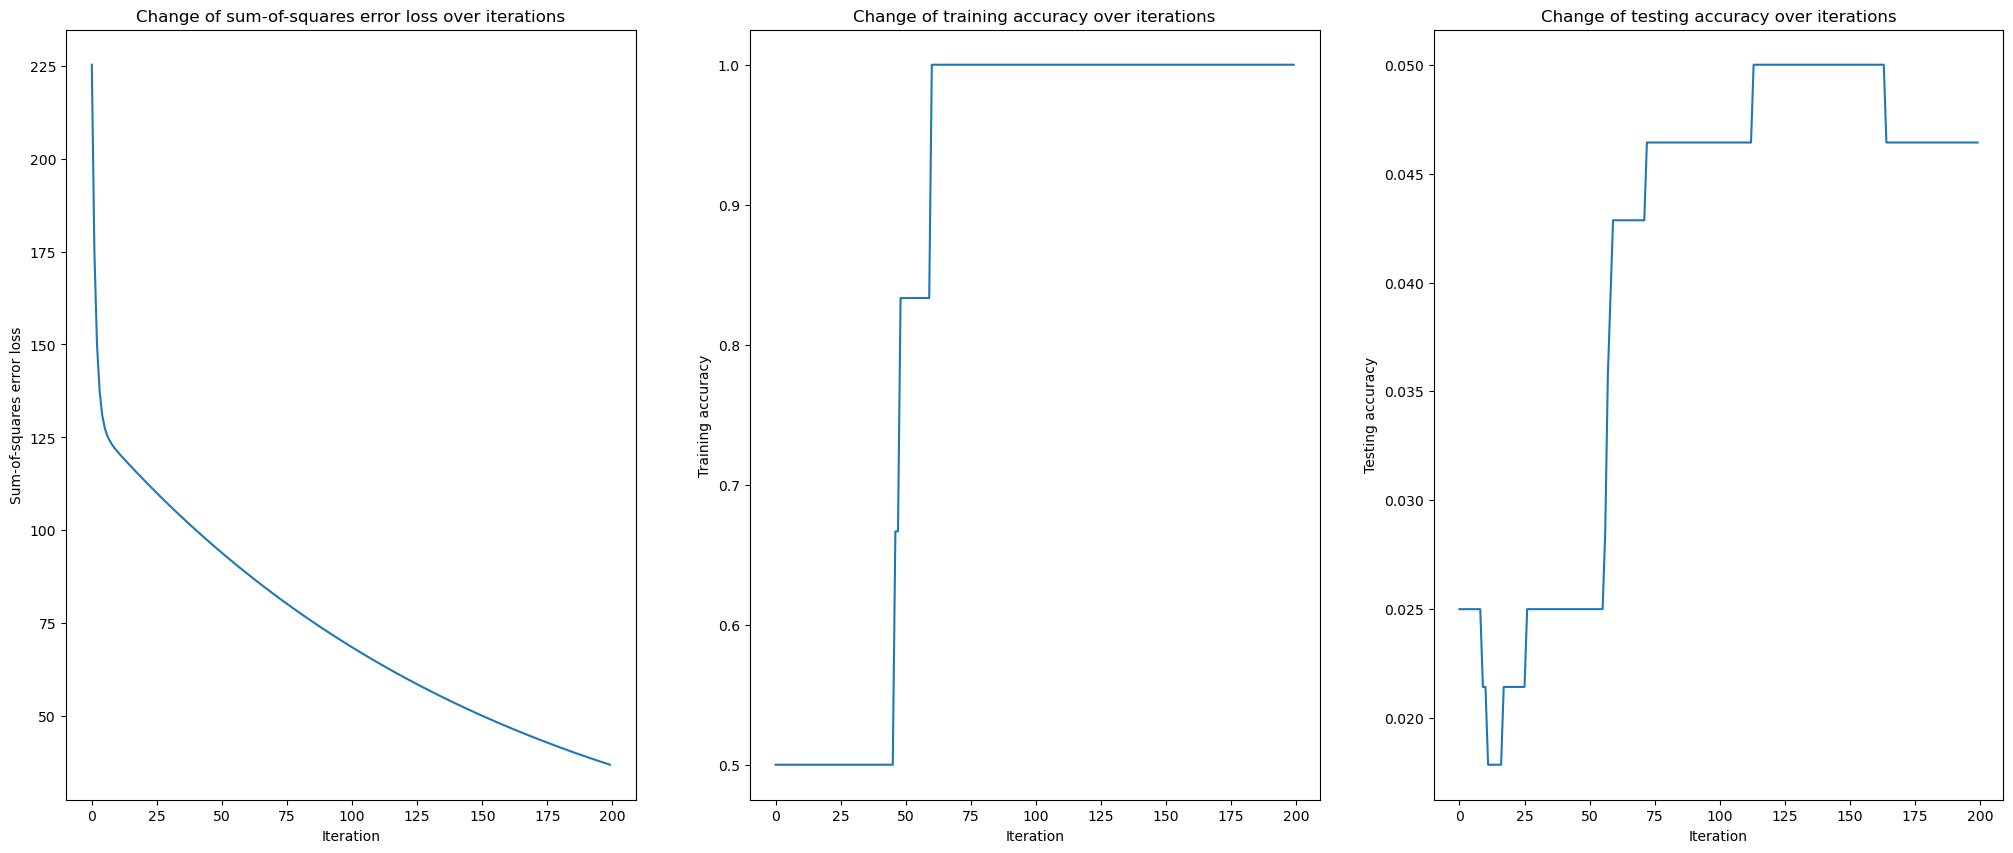

In [548]:
#EXPERIMENT

# Train the model using gradient descent
N = 200
learning_rate = 0.001
cost_all, w_all = lls_gd_train(train_data, train_labels, N, learning_rate)
# print(cost_all)


tr_acc = [] 
te_acc = []

X_tilde_train = np.hstack((np.ones((train_data.shape[0],1)),train_data))

X_tilde_test = np.hstack((np.ones((test_data.shape[0],1)),test_data))

for weights in w_all: 
    train_prediction = np.where((np.dot(X_tilde_train, weights) < 15 ), 1, 30)
    train_acc_iter = np.mean(train_prediction == train_label)
    tr_acc.append(train_acc_iter)

    test_prediction = np.where(((np.dot(X_tilde_test, weights))<15), 1, 30)
    test_acc_iter = np.mean(test_prediction == test_label)
    te_acc.append(test_acc_iter)


    
# Plot the cost and accuracy over iterations
fig, axs = plt.subplots(1, 3, figsize=(25,10))

axs[0].plot(cost_all)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Sum-of-squares error loss')
axs[0].set_title('Change of sum-of-squares error loss over iterations')

axs[1].plot(tr_acc)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training accuracy')
axs[1].set_title('Change of training accuracy over iterations')

axs[2].plot(te_acc)
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Testing accuracy')
axs[2].set_title('Change of testing accuracy over iterations')

plt.show()



Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it runs. 

In [514]:
#SETUP 
# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)

ind_1 = tr_ind[0:3]
ind_30 = tr_ind[87:90]
total_train_ind = np.concatenate((ind_1,ind_30))

train_data = data[total_train_ind, :]
train_label = labels[total_train_ind]

ind_1 = te_ind[0:7]
ind_30 = te_ind[203:210]

total_test_ind = np.concatenate((ind_1,ind_30))

test_data = data[te_ind, :]
test_label = labels[te_ind]


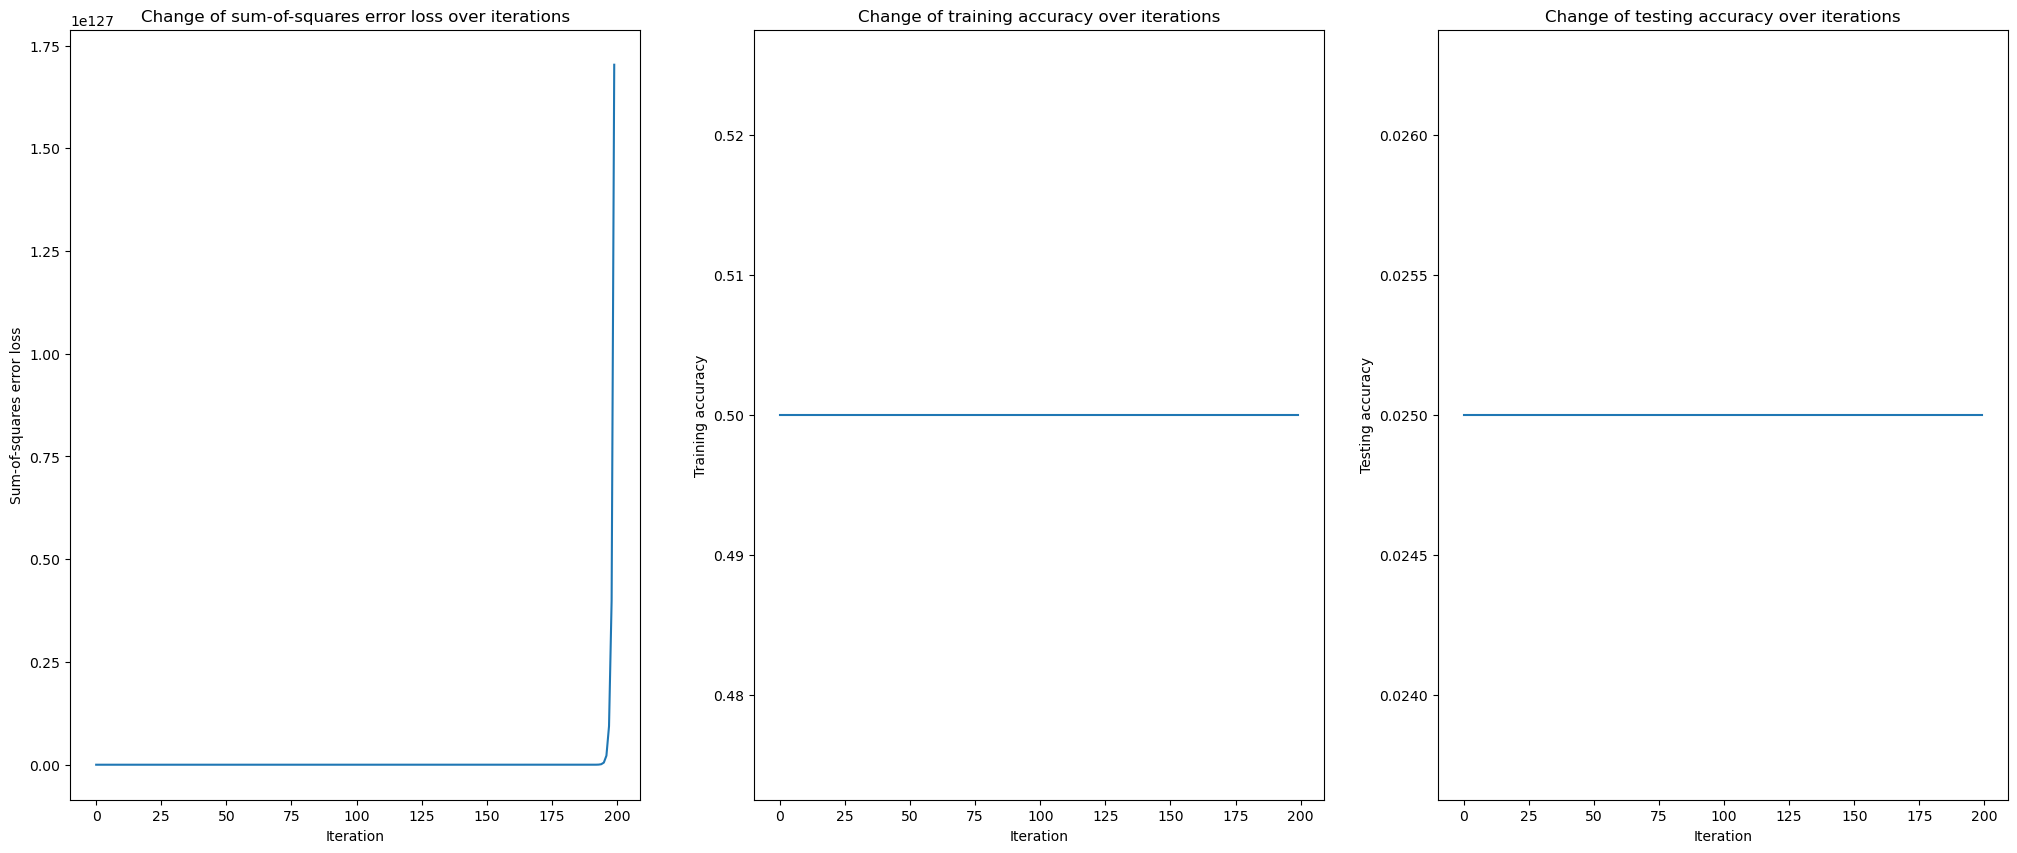

In [515]:
#EXPERIMENT 

# Train the model using gradient descent
N = 200
learning_rate = 0.01
cost_all, w_all = lls_gd_train(train_data, train_labels, N, learning_rate)

tr_acc = [] 
te_acc = []

X_tilde_train = np.hstack((np.ones((train_data.shape[0],1)),train_data))

X_tilde_test = np.hstack((np.ones((test_data.shape[0],1)),test_data))

for weights in w_all: 
    train_prediction = np.where((np.dot(X_tilde_train, weights) < 15 ), 1, 30)
    train_acc_iter = np.mean(train_prediction == train_label)
    tr_acc.append(train_acc_iter)

    test_prediction = np.where(((np.dot(X_tilde_test, weights))<15), 1, 30)
    test_acc_iter = np.mean(test_prediction == test_label)
    te_acc.append(test_acc_iter)


    
# Plot the cost and accuracy over iterations
fig, axs = plt.subplots(1, 3, figsize=(25,10))

axs[0].plot(cost_all)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Sum-of-squares error loss')
axs[0].set_title('Change of sum-of-squares error loss over iterations')

axs[1].plot(tr_acc)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training accuracy')
axs[1].set_title('Change of training accuracy over iterations')

axs[2].plot(te_acc)
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Testing accuracy')
axs[2].set_title('Change of testing accuracy over iterations')

plt.show()



### 6.3 Report
Analyse the impact that changing the learning rate has on the cost function and obtained testing accuracies over each iteration in experiment 6.2. Drawing from what you observed in your experiments, what are the consequences of setting the learning rate and iteration number too high or too low? 

## 7. Advanced Gradient-based Training
For this section, you may choose to implement **either Option 1: SGD** (4 marks), or **Option 2: GD with hinge loss** (7 marks). 

*Please note: Option 1 is easier, but gives fewer potential marks. Option 2 is designed to be a steep challenge, potentially involves mathematical derivations not shown in your notes, and will be marked rigorously. Choose wisely!*

### Option 1: Compare with stochastic gradient descent training (4 marks, Normal)
### 7.1 SGD Implementation 
Replace the gradient descent approach that you did in Section 6.1 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt a similar implementation template to that of your `lls_gd_train` function.

In [537]:
#SGD FUNCTION

import numpy as np

def lls_sgd_train(data, labels, N, learning_rate, batch_size=1):
    """
    Trains a single-output linear model by minimizing the sum of squares loss using stochastic gradient descent.

    data: numpy array of shape (m, n), where m is the number of examples and n is the number of features.
    labels: numpy array of shape (m, 1), where m is the number of examples.
    N: number of iterations to run the stochastic gradient descent algorithm.
    learning_rate: the learning rate to be used in the stochastic gradient descent algorithm.
    batch_size: the size of each mini-batch. Default value is 1.

    Returns:
    cost_all: a numpy array of shape (N,) containing the cost of the linear least squares model at each iteration.
    w_all: a numpy array of shape (N, n+1) containing the weights of the linear least squares model at each iteration.
    """

    # This is just to be consistent with the lecture notes.
    X, y = data, labels

    # Expand X with a column of ones.
    X_tilde = np.hstack((np.ones((X.shape[0],1)),X))

    # Weight initialization
    w = np.zeros(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((N, X_tilde.shape[1]))
    cost_all = np.zeros((N))

    # SGD update of weights
    for i in range(N):

        # cost and stochastic gradient descent of the linear least squares model
        idx = np.random.choice(X_tilde.shape[0], batch_size, replace=False)
        X_batch = X_tilde[idx]
        y_batch = y[idx]
        y_pred = np.dot(X_batch, w)
        error = y_batch - y_pred
        cost = np.sum(error ** 2) / (2 * batch_size)

        dp = np.dot(X_batch, w)
        gradient = (np.dot(X_batch.T, dp) - np.dot(X_batch.T, y_batch))
        gradient /= batch_size

        # Weight update
        w -= (learning_rate * gradient)

        # save w and cost of each iteration in w_all and cost_all 
        w_all[i] = w
        cost_all[i] = cost

    # Return model parameters.
    return cost_all, w_all



### 7.2 Experiment Design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference between gradient descent and stochastic gradient descent. 


In [538]:
#SETUP 
# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)

ind_1 = tr_ind[0:3]
ind_30 = tr_ind[87:90]
total_train_ind = np.concatenate((ind_1,ind_30))

train_data = data[total_train_ind, :]
train_label = labels[total_train_ind]

ind_1 = te_ind[0:7]
ind_30 = te_ind[203:210]

total_test_ind = np.concatenate((ind_1,ind_30))

test_data = data[te_ind, :]
test_label = labels[te_ind]



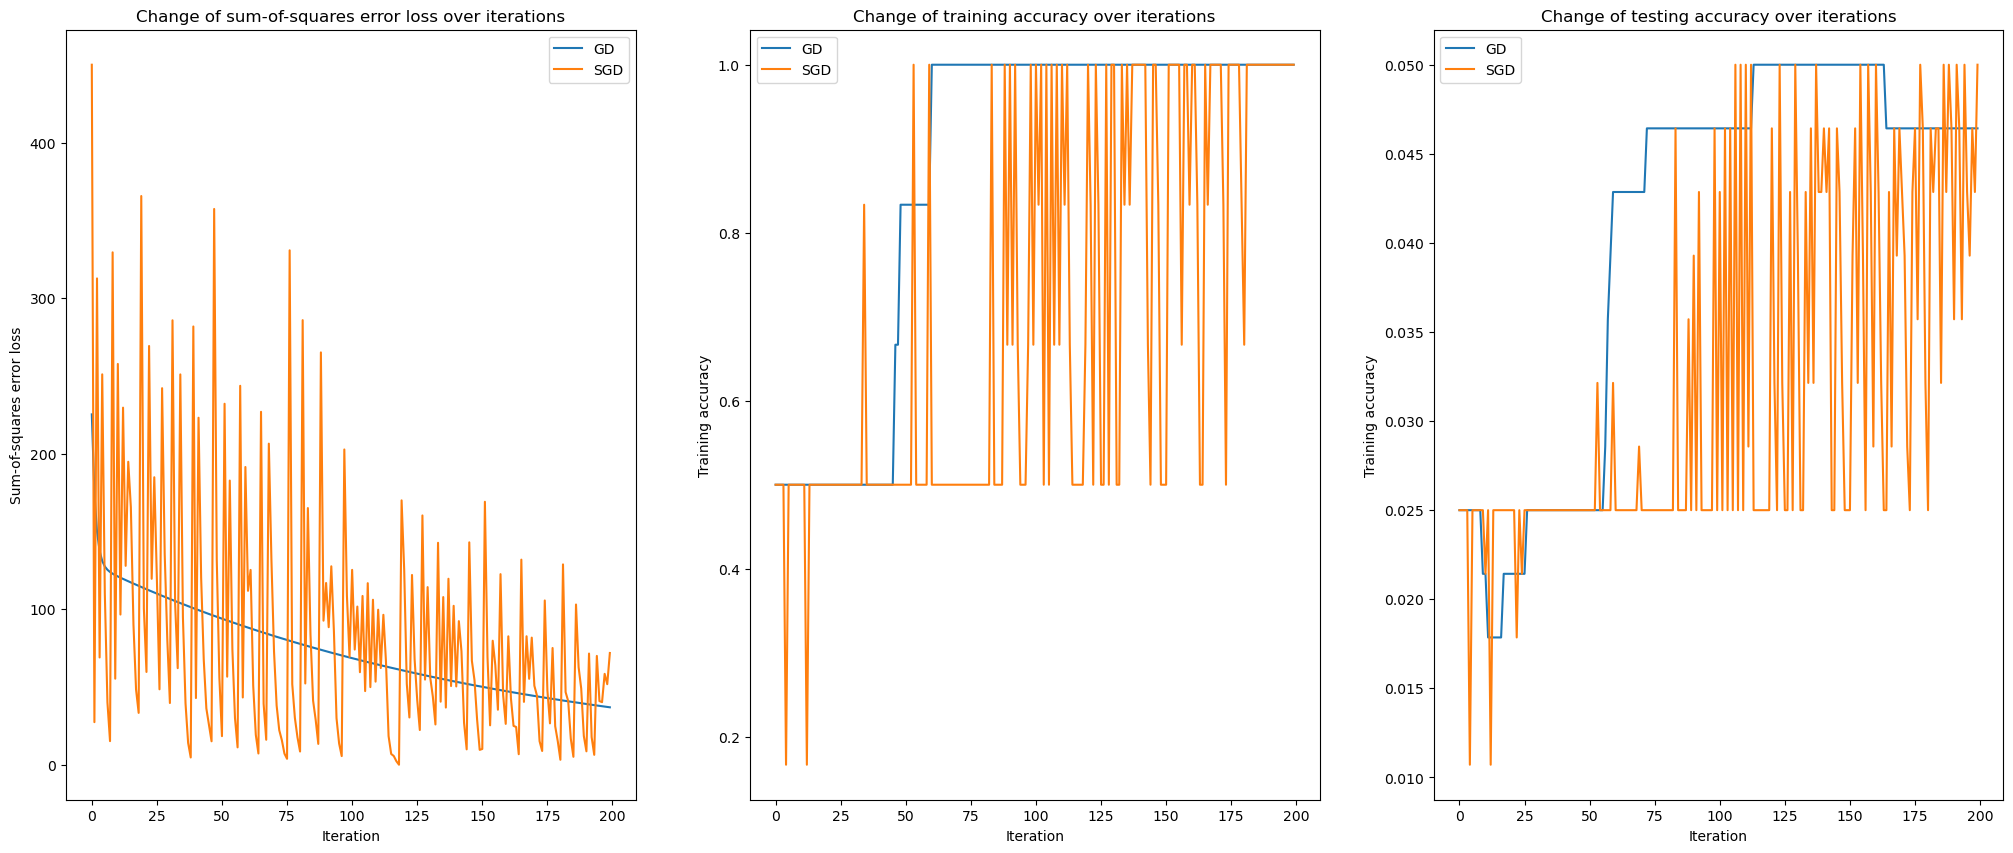

In [544]:
# Experiment
# Train the model using GD
N = 200
learning_rate = 0.001
cost_all_gd, w_all_gd = lls_gd_train(train_data, train_labels, N, learning_rate)

# Train the model using SGD
batch_size = 1
cost_all_sgd, w_all_sgd = lls_sgd_train(train_data, train_labels, N, learning_rate, batch_size)

# Record the accuracy of the models
X_tilde_train = np.hstack((np.ones((train_data.shape[0],1)), train_data))
X_tilde_test = np.hstack((np.ones((test_data.shape[0],1)), test_data))

tr_acc_gd = []
te_acc_gd = []
tr_acc_sgd = []
te_acc_sgd = []

for weights in w_all_gd:
    train_prediction = np.where((np.dot(X_tilde_train, weights) < 15 ), 1, 30)
    train_acc_iter = np.mean(train_prediction == train_labels)
    tr_acc_gd.append(train_acc_iter)

    test_prediction = np.where(((np.dot(X_tilde_test, weights))<15), 1, 30)
    test_acc_iter = np.mean(test_prediction == test_label)
    te_acc_gd.append(test_acc_iter)

for weights in w_all_sgd:
    train_prediction = np.where((np.dot(X_tilde_train, weights) < 15 ), 1, 30)
    train_acc_iter = np.mean(train_prediction == train_labels)
    tr_acc_sgd.append(train_acc_iter)

    test_prediction = np.where(((np.dot(X_tilde_test, weights))<15), 1, 30)
    test_acc_iter = np.mean(test_prediction == test_label)
    te_acc_sgd.append(test_acc_iter)

# Plot the cost and accuracy over iterations for both GD and SGD
fig, axs = plt.subplots(1, 3, figsize=(25,10))

axs[0].plot(cost_all_gd, label='GD')
axs[0].plot(cost_all_sgd, label='SGD')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Sum-of-squares error loss')
axs[0].set_title('Change of sum-of-squares error loss over iterations')
axs[0].legend()

axs[1].plot(tr_acc_gd, label='GD')
axs[1].plot(tr_acc_sgd, label='SGD')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Training accuracy')
axs[1].set_title('Change of training accuracy over iterations')
axs[1].legend()

axs[2].plot(te_acc_gd, label='GD')
axs[2].plot(te_acc_sgd, label='SGD')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Training accuracy')
axs[2].set_title('Change of testing accuracy over iterations')
axs[2].legend()



### 7.3 Report

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

**Remember that all graphs should have axis labels and a title.**

### Option 2: Gradient descent training using hinge loss (7 marks, Hard)
Here is a recap of Hinge loss. For a single output model, the hinge loss over N training samples is $$O(\theta) = \sum^N_{i=1}\max\left(0, 1 - y_i f(\theta, x_i)\right)$$ where $y_i \in \{-1, +1\}$ is the class target label and $f(\theta, x_i)$ is your prediction function. While this is not directly differentiable, we can split it into two separately differentiable parts. For one sample, the above formuation is equivalent to:
$$
\max\left(0, 1 - y_i f(\theta, x_i)\right) = \begin{cases}
    0 & \text{if } y_i f(\theta, x_i) \geq 1 \\ % & is your "\tab"-like command (it's a tab alignment character)
    1-y_i f(\theta, x_i) & \text{otherwise.}
\end{cases}
$$

### 7.1 Implementation
Apply the gradient descent approach to train your classifier but by minimising the hinge loss. Implement the function `hinge_gd_train` below. 

`hinge_gd_train` trains a single-output linear model by minimising the hinge loss using the gradient descent approach. The optimisation function should include a regularisation term and regularisation hyperparameter $C$. It should take the iteration number $N$, the learning rate $\eta$, and regularisation hyperparameter $C$ as arguments. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of the regularised hinge loss model calculated in all the iterations.

In [518]:
def hinge_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    # This is just to be consistent with the lecture notes.
    X, y = data, labels

    # Initialise arrays to store weights and cost at each iteration
    w_all = ...
    cost_all = ...

    # Your code goes here
    
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear hinge loss model
        cost = ...
        
        # save w and cost of each iteration in w_all and cost_all


    # Return model parameters.
    return cost_all, w_all


### 7.2 Experiment design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference for gradient descent training based on the least squared loss and the hinge loss. 


In [519]:
# Your code goes here

### 7.3 Report

Explain in your report the following: 

(1) Your implementation of `hinge_gd_train`. If you analytically derived the loss function, please include it here.

(2) Your experiment design, comparative result analysis and interpretation of obtained results. 

**Remember that all graphs should have axis labels and a title.**